# Do visualizations of Results
Cells are independent vizualiations of figures

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from scipy.stats import binned_statistic  # For Binning

import matplotlib.cm as cm
import matplotlib.colorbar as clb
from matplotlib import gridspec

import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [55]:
def load_data(folder="../Simulated/Example0/", empirical=False, fullpost=False, viterbi=False):
    """Load and return the Data from one Data Folder"""
    
    ob_stat = np.loadtxt(folder + "hap.csv", dtype="int", delimiter=",")
    
    if viterbi:
        viterbi_path = np.loadtxt(folder + "viterbi_path.csv", dtype="int", delimiter=",")
    else:
        viterbi_path = []
    
    if empirical==False:
        lats = np.loadtxt(folder + "lat.csv", dtype="int", delimiter=",")
        ref_states = np.loadtxt(folder + "refs.csv", dtype="int", delimiter=",")
        roh_df = 0
        read_counts = 0
        gmap = 0
        posterior = np.loadtxt(folder + "posterior.csv", dtype="float", delimiter=",")
        
    elif empirical:
        lats = 0
        roh_df  = pd.read_csv(folder + "roh.csv", delimiter=",")
        read_counts = np.loadtxt(folder + "readcounts.csv", delimiter=",")
        gmap = np.loadtxt(folder + "map.csv", dtype="float", delimiter=",")
        
        if fullpost==True:
            posterior = np.loadtxt(folder + "posterior.csv", dtype="float", delimiter=",")  # For Plot of all Posteriors   
        else:
            posterior = np.loadtxt(folder + "posterior0.csv", dtype="float", delimiter=",")
            
        ref_states = np.zeros(np.shape(posterior)) # Just some Filler for the Moment
        
    else:
        raise RuntimeError("WTF DUDE")

    print(f"Successfully loaded Data from: {folder}")
    return (ref_states, ob_stat, lats, viterbi_path, 
            posterior, roh_df, read_counts, gmap)

### Some more Helper Functions
def process_read_counts(read_counts, m=1):
    """Return Readcount that have at least m reads for both Ref and Alt"""
    hets = (read_counts[0,:]>=m) & (read_counts[1,:]>=m)
    return hets

# Plot Viterbi Paths

In [25]:
def plot_viterbi(folder = "../Simulated/Test20r/", save=True, empirical=False):
    """Plot Viterbi Path of Haplotype copying"""
    ref_states, ob_stat, lats, viterbi_path, _, _, _, _ = load_data(folder=folder, empirical=empirical, fullpost=True, viterbi=True)
    ###########################
    ###########################

    fs = 16

    plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
    gs.update(hspace=0.3) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one

    ax.imshow(ref_states, cmap='Greys',  aspect='auto')
    if empirical == False:
        ax.plot(lats[:]-1.5, linewidth=2, color="yellow", label="Copying State") # Plot upper Boarder
        ax.plot(lats[:]-0.5, linewidth=2, color="yellow") # Plot lower boarder

     #   ax.plot(lats[1,:]-1.5, linewidth=2, color="red") # Plot upper Boarder
     #   ax.plot(lats[1,:]-0.5, linewidth=2, color="red") # Plot lower boarder

    ax.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")

    ax.set_ylabel("Ref. Hapotype",fontsize=fs)
    #ax.axhline(-.3)
    ax.set_xticks([])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=fs) # Do the Legend

    # Do the Reference SNP:
    ax1.imshow(ob_stat, cmap='Greys',  aspect='auto')
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_yticks([])
    ax1.set_ylabel("Copy")
    
    ax.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")
    
    
    if save==True:
        plt.savefig(folder + "viterbi_path.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [15]:
#plot_viterbi(folder = "../Simulated/Test20r/", empirical=False, save=False)
plot_viterbi(folder = "../Empirical/AncSards/MA89_1000G_ROH/chr4/", empirical=True, save=False)

# Plot Posterior along Chromosomes

In [56]:
def plot_posterior(folder = "../Simulated/Test20r/", save=True, empirical=False):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states"""
    ref_states, ob_stat, lats, viterbi_path,  \
            posterior, roh_df, read_counts, gmap = load_data(folder, empirical, fullpost=True)
    
    #if empirical == True:
    #    ref_states = np.array([ref_states[i,:] != ref_states[0,:] for i in range(len(ref_states))])  # Polarize Markers
        
    ###########################
    ###########################
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 16

    plt.figure(figsize=(12,10))
    gs = gridspec.GridSpec(4, 1, height_ratios=[10, 1, 10, 1])
    gs.update(hspace=0.2) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
    ax2 = plt.subplot(gs[2]) # The likelihood subplot
    ax3 = plt.subplot(gs[3])

    ax.imshow(ref_states, cmap='Greys',  aspect='auto')
    if empirical == False:
        ax.plot(lats[:] - 1.5, linewidth=1.5, color="yellow", label="Latent State1") # Plot upper Boarder
        ax.plot(lats[:] - 0.5, linewidth=1.5, color="yellow") # Plot lower boarder
        ax.plot(lats[:] - 1.5, linewidth=1.5, color="red", label="Latent State2") # Plot upper Boarder
        ax.plot(lats[:] - 0.5, linewidth=1.5, color="red") # Plot lower boarder

    ax.set_ylabel("Ref. Hapotype",fontsize=fs)
    #ax.axhline(-.3)
    ax.set_xticks([])

    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=fs) # Do the Legend

    # Do the Reference SNP
    ax1.imshow(ob_stat, cmap='Greys',  aspect='auto')
    ax1.set_yticks([])
    ax1.set_ylabel("Copy")
    ax1.set_xlabel("SNP", fontsize=fs, labelpad=-10)
    
    # Do the Viridis CMAP:
    
    # Do the Posterior:
    ax2.imshow(posterior, aspect='auto', cmap=cmap, norm=norm)
    
    if empirical == False:
        ax2.plot(lats[:] - 0.5, linewidth=1.5, color="yellow", label="Latent State1") # Plot upper Boarder
        ax2.plot(lats[:] + 0.5, linewidth=1.5, color="yellow") # Plot lower boarder
        #ax2.plot(lats[1,:] - 0.5, linewidth=1.5, color="red", label="Latent State2") # Plot upper Boarder
        #ax2.plot(lats[1,:] + 0.5, linewidth=1.5, color="red") # Plot lower boarder
        #ax2.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")x2.plot(viterbi_path-1.0, linewidth=4, color="blue", label="Viterbi Path")
        ax2.set_ylabel("Posterior of States", fontsize=fs)
    
    ### Color Map
    cb1 = clb.ColorbarBase(ax3, cmap=cmap,
                            norm=norm,   # For the /1e3 format
                            orientation='horizontal')
    
    ax3.set_xlabel("Log Likelihood", fontsize=fs)
    #cb1.ax.tick_params(axis='y', direction='in')
    #cb1.ax.yaxis.tick_left()
    
    if save==True:
        plt.savefig(folder + "posterior.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    ###########################################
    ### Plot the Posterior for State 0
    
    plt.figure(figsize=(12,4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10])
    gs.update(hspace=0.1) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
    
    #print(lats==0)
    #ax.imshow([lats[0,:]==lats[1,:]],  cmap='Greys_r',  aspect='auto')
    homo = (ob_stat[0,:]==ob_stat[1,:])
    ax.imshow([homo, homo], cmap='Greys_r',  aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Homozygosity", fontsize=fs)
    
    ax1.plot(np.exp(posterior[0,:]), linewidth=4, color="maroon", label="State 0")
    #ax1.legend(fontsize=fs, loc="lower center")
    ax1.set_xlim(0, np.shape(posterior)[1])
    ax1.set_ylabel("Posterior Probability", fontsize=fs)
    ax1.set_xlabel("SNP", fontsize=fs)
    
    if save==True:
        plt.savefig(folder + "posterior_HW.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    
    
def plot_posterior_cm(folder = "../Simulated/Test20r/", savepath="", empirical=True, 
                      plot=True, cm_lim=[], m=1, groundtruth=False, readcount=False, 
                     plot_hets=True, plot_calls=True, plot_post=True,
                      figsize=(14,4)):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states
    cm_lim: What Area to Zoom In (CentiMorgan)
    m: How many reads for ref and alt
    groundtruth: Whether to plot Ground Truth (saved as csv)
    plot_hets: Whether to plot Heterozygote Markers
    plot_calls: Whether to plot Calls
    plot_post: Whether to plot posterior"""
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 16
    lw = 6 # Linewidth for ROH
    
    _, ob_stat,_,_,posterior, roh_df, read_counts, gmap = load_data(folder, empirical)
    assert(len(gmap)==np.shape(ob_stat)[1])
        
    ###########################
    ###########################
    # Do the Plot
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 8])
    gs.update(hspace=0.3) # set the spacing between axes. 

    #ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower subplot
    
    ### Depict Readcounts or GT Heteroyzgotes
    if readcount == False:
        het = (ob_stat[0,:] != ob_stat[1,:])
    elif readcount == True:
        het = process_read_counts(read_counts, m=m)
    else:
        raise RuntimeError("Invalid Mode!")
        
    #ax.plot(gmap*100, het, "bo", ms=2, alpha=0.3)
    #ax.set_ylabel("Het", fontsize=fs)
    #ax.set_title("Hetorzygosity", fontsize=fs)
    if plot_post == True:
        ax1.plot(gmap*100, np.exp(posterior), linewidth=2, color="maroon", label="State 0", zorder=1)
    
    if plot_hets==True:
        ax1.plot(gmap*100, (het * 1.1 - 0.05), "bo", ms=1, alpha=0.3,zorder=0)
    
    if plot_calls==True:
        plt.hlines(y=[1.12]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                        colors="green", linewidth=lw)
    
    ax1.set_ylabel("Post. Probability", fontsize=fs)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if len(cm_lim)==2:
        ax1.set_xlim(cm_lim)
        
    ### Load & Plot Groundtruth (if given):
    if groundtruth==True:
        path = folder + "roh_gt.csv"
        dft = pd.read_csv(path, sep="\t")
        
        ### Plot them
        plt.hlines(y=[1.2]*len(dft), xmin=100 * dft["ROH_Begin"], xmax= 100 * dft["ROH_End"], 
                    colors="blue", linewidth=lw)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        #plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot==True:
        plt.show()

Successfully loaded Data from: ../Empirical/AncSards/MA89_1000G_ROH/chr3/


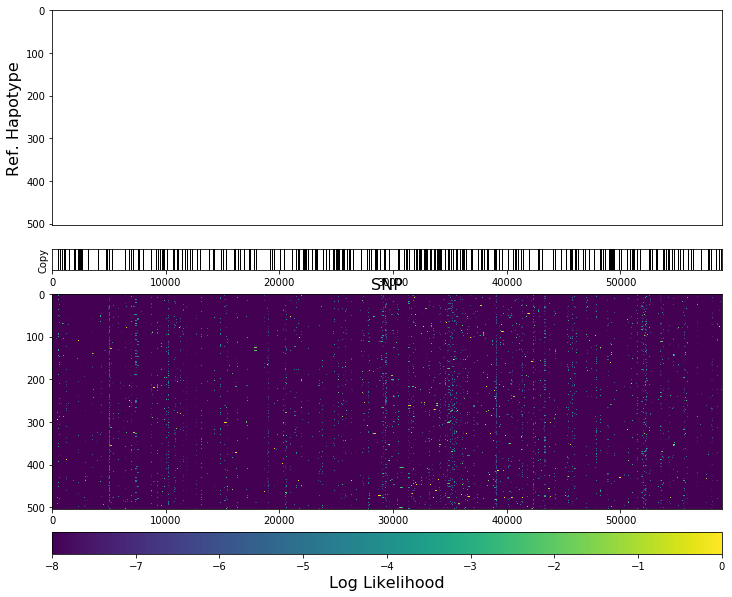

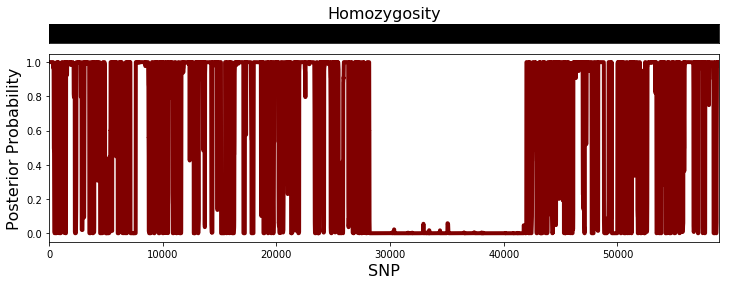

In [6]:
#process_read_counts(read_counts, m=1)
#plot_posterior(folder = "../Simulated/Test20r/", save=True)
#plot_posterior(folder = "../Empirical/1kEUR_ROH9/", save=True, empirical=True)
#plot_posterior(folder = "../Empirical/Sard100_0-10kROH6/", save=True, empirical=True)
plot_posterior(folder = "./Empirical/AncSards/MA89_1000G_ROH/chr3/", save=True, empirical=True)

### Do the Empirical Plot (with Linkage Maps)

Successfully loaded Data from: ./Empirical/HO/Surui_0/chr19/


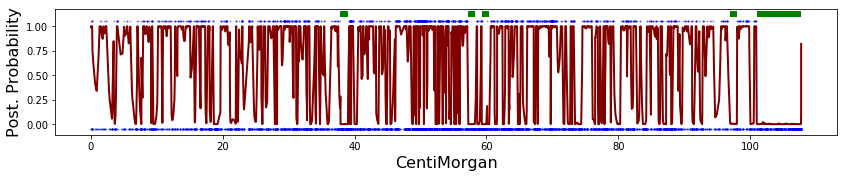

In [77]:
#plot_posterior_cm(folder = "../Empirical/AncSards/MA89_1000G_ROH_v1/chr5/", save=True, 
#                  empirical=True, m=2, cm_lim=[])  #d05e

#plot_posterior_cm(folder = "./Empirical/SEC002_1000G_ROH/chr15/", save=True, 
#                  empirical=True, m=1, cm_lim=[])  #d05e

plot_posterior_cm(folder = "./Empirical/HO/Surui_0/chr19/", 
                  empirical=True, cm_lim=[], readcount=False)  # MA89 Chr8

#plot_posterior_cm(folder = "./Empirical/1240k/ORC008/chr1/e01/", save=False, 
#                  empirical=True, m=1, cm_lim=[50, 100])  # MA89 Chr8

### Plot Simulated Individual

Successfully loaded Data from: ./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/


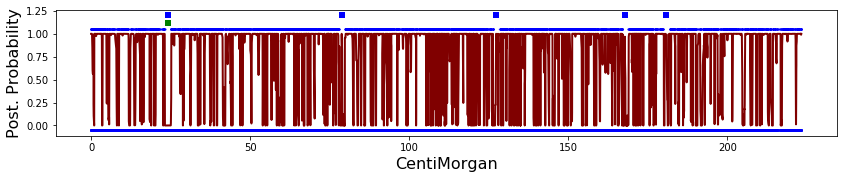

In [57]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = False) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/allRef/


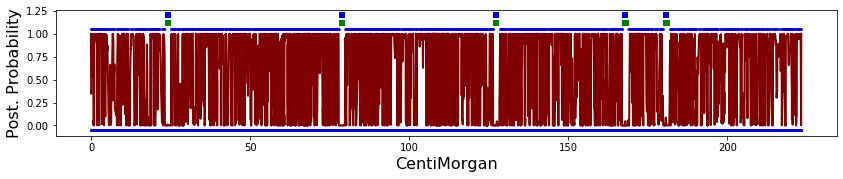

In [56]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/YRI/ch3_2cm/output/iid20/chr3/allRef/", 
                  empirical=True, m=1, cm_lim=[], groundtruth = True, readcount = False) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid6/chr3/ROHin100/


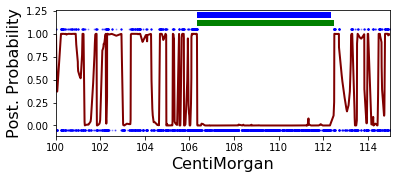

In [29]:
#plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/", save=False, 
#                  empirical=True, m=2, cm_lim=[], groundtruth = True, readcount=True) 

plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid6/chr3/ROHin100/", figsize=(6,4),
                  empirical=True, m=1, cm_lim=[100,115], groundtruth = True, readcount=False, savepath="./figures/talk_harvard/TSI5_ch3_6cm.png",
                 plot_post=True)

# Compare handpicked and ML parameters

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/


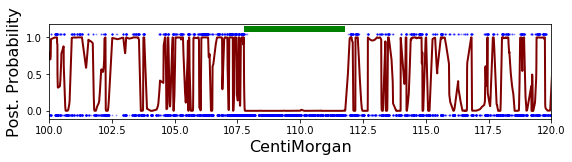

In [66]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/", savepath="./figures/talk_harvard/ROHin100ch3iid0_gt.pdf", 
                  empirical=True, m=2, cm_lim=[100, 120], groundtruth = False, plot_hets = True, plot_calls=True, 
                 figsize=(9, 3)) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/ch3_4cm/output/iid0/chr3/e01/


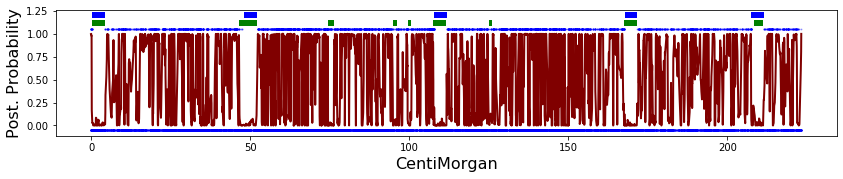

In [8]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/ch3_4cm/output/iid0/chr3/e01/", savepath="", 
                  empirical=True, m=2, cm_lim=[], groundtruth = True)

### Compare All Reference with European Reference only

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/allRef300/


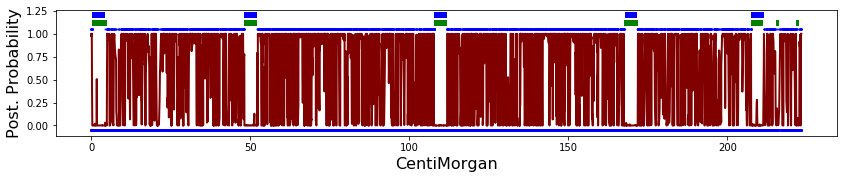

In [6]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/allRef300/", 
                  empirical=True, cm_lim=[], groundtruth = True) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/


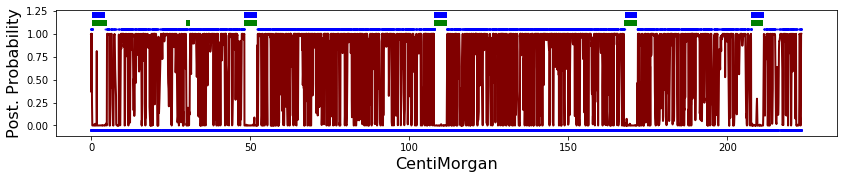

In [5]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/ROHin100/", 
                  empirical=True, cm_lim=[], groundtruth = True) 

### Plot Empirical Individuals

Successfully loaded Data from: ./Empirical/1240k/SEC002/chr1/e01/


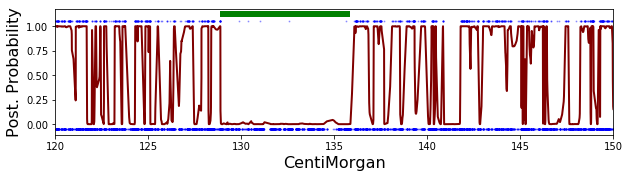

In [22]:
plot_posterior_cm(folder = "./Empirical/1240k/SEC002/chr1/e01/", savepath="", 
                  empirical=True, m=1, cm_lim=[120,150], groundtruth = False, readcount=True, figsize=(10,4),
                 )   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/MA89/chr4/e01/


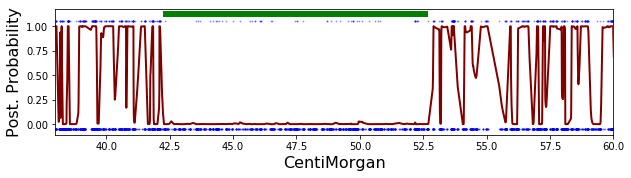

In [101]:
plot_posterior_cm(folder = "./Empirical/1240k/MA89/chr4/e01/", savepath="./figures/talk_harvard/MA89chr4m1.pdf", 
                  empirical=True, m=1, cm_lim=[38,60], groundtruth = False, readcount=True, figsize=(10,4),
                 )   # ./Empirical/1240k/SEC002/chr20/e01/

Successfully loaded Data from: ./Empirical/1240k/Ogl_5/chr7/e01/


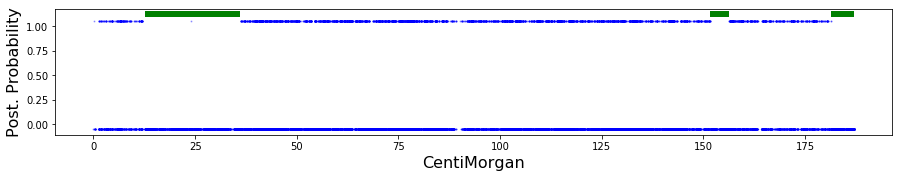

In [7]:
plot_posterior_cm(folder = "./Empirical/1240k/Ogl_5/chr7/e01/", figsize=(15,4),
                  empirical=True, m=1, cm_lim=[], groundtruth = False, readcount=False, savepath="./figures/talk_harvard/ogl5_chr7.png",
                 plot_post=False)

Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr3/e01/


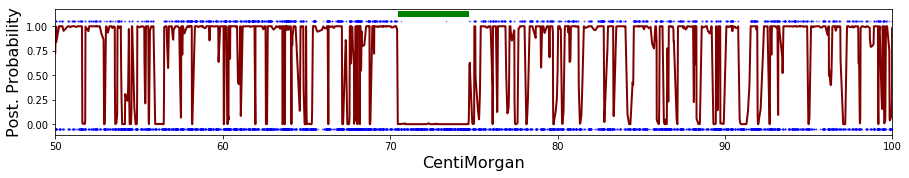

In [14]:
plot_posterior_cm(folder = "./Empirical/1240k/HO/Turkish_3/chr3/e01/", figsize=(15,4),
                  empirical=True, m=1, cm_lim=[50,100], groundtruth = False, readcount=False, savepath="",
                 plot_post=True)

# Compare hanpicked and ML (only ROH385)

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/baseline/


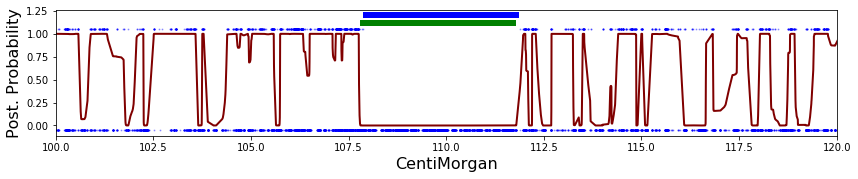

In [76]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/baseline/", save=False, 
                  empirical=True, m=2, cm_lim=[100,120], groundtruth = True) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/maxll/


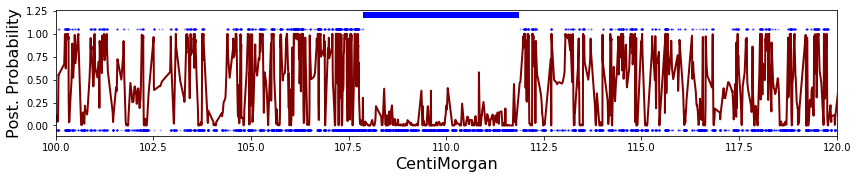

In [75]:
plot_posterior_cm(folder = "./Simulated/1000G_Mosaic/TSI5/ch3_4cm/output/iid0/chr3/maxll/", save=False, 
                  empirical=True, m=2, cm_lim=[100,120], groundtruth = True)

# Plot smoothed Prior (and real prior)

In [9]:
def smooth_posterior(posterior, gmap, step=0.1):
    """Smooths the Posterior.
    gmap: In cM
    Step: In cM"""
    min_cm = np.min(gmap)
    max_cm = np.max(gmap)
    bins = np.arange(min_cm, max_cm, step)  # Create the binning
    
    bin_means, bin_edges, _ = binned_statistic(gmap, posterior, statistic="mean", bins = bins)
    
    return bin_means, bin_edges

def sliding_window_posterior(posterior, gmap, step=0.1):
    """Do a Sliding Window Approach"""
    
    dist = np.abs(gmap[:,None] - gmap) < step
    snps_reach = np.sum(dist, axis=1)  # How many SNPs are in reach for every SNP
    posterior_sw = np.dot(dist, posterior) / snps_reach
    
    return posterior_sw
    

def plot_posterior_smooth_cm(folder = "../Simulated/Test20r/", save=False, empirical=True, 
                      plot=True, cm_lim=[], m=1, groundtruth=False, mosaic=False, bin_width=100, smooth_step=0.1):
    """Plot Viterbi Path of Haplotype copying.
    save: Whether to save the results.
    empirical: If true, do not load and plot latent states
    cm_lim: What Area to Zoom In (CentiMorgan)
    m: How many reads for ref and alt
    groundtruth: Whether to plot Ground Truth (saved as csv)"""
    
    cmap = cm.get_cmap("viridis")
    norm = plt.Normalize(-8, 0)

    fs = 16
    lw = 6 # Linewidth for ROH
    
    _, ob_stat,_,_,posterior, roh_df, read_counts, gmap = load_data(folder, empirical)
    assert(len(gmap)==np.shape(ob_stat)[1])
    
    ### Smooth the Posterior
    posterior_sw = sliding_window_posterior(np.exp(posterior), gmap*100, step=smooth_step)
    
    ###########################
    ###########################
    # Do the Plot
    
    plt.figure(figsize=(14,3))    
    ax1 = plt.gca()
    
    het = (ob_stat[0,:]!=ob_stat[1,:])
    if empirical==True:  
        het = process_read_counts(read_counts, m=m)       
    if mosaic == True:
        het = (ob_stat[0,:] != ob_stat[1,:])
    
    ax1.plot(gmap*100, np.exp(posterior), linewidth=2, color="gray", label="State 0", zorder=1)
    ax1.plot(gmap*100, posterior_sw, linewidth=3, color="red", zorder = 2) # Plot the sliding window posterior   
    ax1.plot(gmap*100, (het * 1.1 - 0.05), "bo", ms=1, alpha=0.3, zorder=0)  # Plot Heterozygosity
    
    #bin_means, bin_edges = smooth_posterior(np.exp(posterior), gmap*100, step=smooth_step)
    #plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='red', lw=3, zorder=2)
    
    plt.hlines(y=[1.12]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                    colors="green", linewidth=lw)
    
    ax1.set_ylabel("Post. Probability", fontsize=fs)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if len(cm_lim)==2:  ### If correct format Limit is given
        ax1.set_xlim(cm_lim)    
        
    ### Load & Plot Groundtruth (if given):
    if groundtruth==True:
        path = folder + "roh_gt.csv"
        dft = pd.read_csv(path, sep="\t")
        
        ### Plot them
        plt.hlines(y=[1.2]*len(dft), xmin=100 * dft["ROH_Begin"], xmax= 100 * dft["ROH_End"], 
                    colors="blue", linewidth=lw)
        
    if save==True:
        plt.savefig(folder + "posterior_cm.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(folder + "posterior_cm.png", bbox_inches = 'tight', pad_inches = 0, dpi=300)
    
    if plot==True:
        plt.show()
        
    return posterior

In [ ]:
%%time
posterior = plot_posterior_smooth_cm(folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/", save=False, 
                  empirical=True, cm_lim=[0,100], groundtruth = True, mosaic=True, smooth_step=0.1) 

Successfully loaded Data from: ./Simulated/1000G_Mosaic/TSI5/lambda_rc3.0/ch3_10cm/output/iid1/chr3/e01/


In [1]:
print("why oh why")

why oh why


# Plot one full Individual
Plot one Individual across all Chromosomes

In [5]:
def plot_full_ROH_ind(iid, chs=[], m=1, save=False, plot=True, prefix_out ="e01/", readcounts=True, folder="./Emprical/1240k/"):
    """Plot Full ROH of a single Individual. Scan over all Chromosomes.
    m: The Level"""
    
    if len(chs)==0:
        chs = np.arange(1,23)  # Do all Chromosomes by default

    folder = folder + iid + "/"

    ### Some Parameters for the Plot
    fs_l = 14  # Font Size Labels
    fs = 10
    lw = 5     # Linewidth for ROH

    ### Create the Figure:
    plt.figure(figsize=(14, 2*len(chs)))
    gs = gridspec.GridSpec(len(chs), 1) # height_ratios=[len(chs) * 2, 8]

    gs.update(hspace=0.2) # set the spacing between axes. 
    axarr = [plt.subplot(gs[i]) for i in range(len(chs))]

    ### Fill it with Data:
    for i, ch in enumerate(chs):
        #print(f"Doing Chromosome: {ch}")
        ax = axarr[i]
        ax.set_ylabel(f"Chr: {ch}", fontsize = fs_l, rotation=270, labelpad=14)
        ax.yaxis.set_label_position("right")

        ### Do the Plotting
        # Load the data
        load_folder = folder + "chr" + str(ch) + "/" + prefix_out
        _, ob_stat, _, _, \
                posterior, roh_df, read_counts, gmap = load_data(load_folder, empirical=True)
        
        if readcounts == True:
            het = process_read_counts(read_counts, m=m)
        else:
            het = (ob_stat[0,:] != ob_stat[1,:])

        ax.plot(gmap*100, np.exp(posterior), linewidth=2, color="maroon", label="State 0", zorder=1)
        ax.plot(gmap*100, (het * 1.1 - 0.05), "bo", ms=1, alpha=0.3,zorder=0)
        ax.hlines(y=[1.15]*len(roh_df), xmin=100 * roh_df["StartM"], xmax= 100 * roh_df["EndM"], 
                        colors="green", linewidth=lw)

    ### Set the XLabel
    axarr[-1].set_xlabel("CentiMorgan", fontsize = fs_l)

    axarr[0].set_title(iid, fontsize=fs_l)
    ### Save as PDF:
    if save==True:
        #plt.savefig(folder + "all_cromsomomesROH.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.savefig(folder + "all_cromsomomesROH.png", bbox_inches = 'tight', pad_inches = 0, dpi=300) #bc why not
    if plot==True:
        plt.show()
    else: plt.close()

Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr1/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr2/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr3/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr4/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr5/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr6/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr7/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr8/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr9/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr10/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr11/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr12/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_3/chr13/e01/
Successfully loaded Data from: ./Empirical/1240k/HO/Turkish_

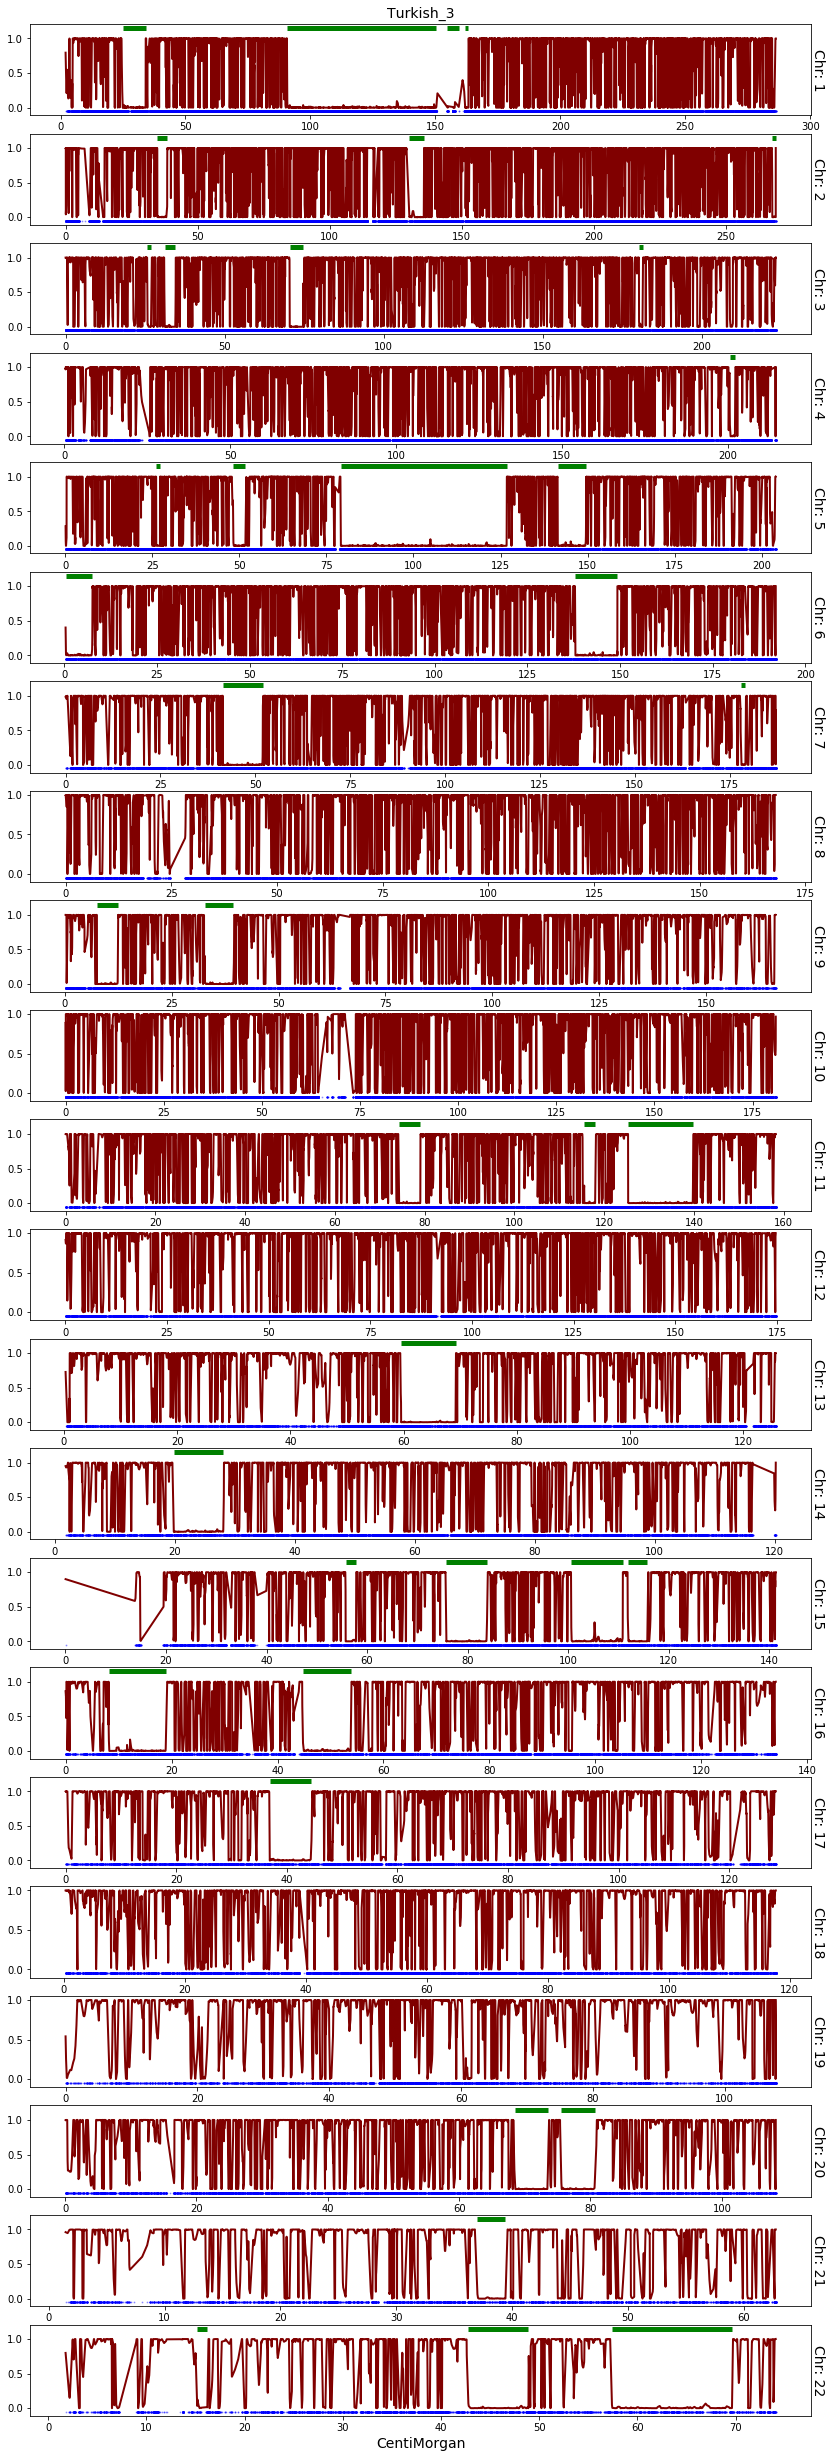

In [10]:
chs = np.arange(1,23)
plot_full_ROH_ind(iid="Turkish_3", chs=chs, m=2, readcounts=True, save=False, folder="./Empirical/1240k/HO/")   ### I2521 I3068 : HG

In [8]:
### Do all ancients Sardinian Individual
def plot_all_ancsards():
    """Make ROH Plot of all ancient Sardinians."""
    meta_path = "../../ancient-sardinia/output/meta/meta_final.csv"
    anc_ind = 1029  # Up to which individual there are ancestrals
    anc_sardind = 57  # Nr of ancient Sarinian individuals
    min_cov = 0.5

    meta_df = pd.read_csv(meta_path)  # Load the Meta File
    as_df = meta_df[:anc_sardind]
    iid_list = as_df[(as_df["mean_cov"] > min_cov)]["iid"].values
    print(f"Found n={len(iid_list)} Inds with Cov > {min_cov}")


    for iid in iid_list:
        chs = np.arange(1,23)
        plot_full_ROH_ind(iid=iid, chs=chs, m=1, save=True, plot=False)

In [ ]:
plot_all_ancsards()

# Area 51